In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  # train_test_split 임포트
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input  # Input 레이어 임포트
from datetime import datetime, timedelta

# 1. 데이터 수집
start = (datetime.now() - timedelta(days=730)).strftime('%Y-%m-%d')  # 데이터 시작 날짜
end = datetime.now().strftime('%Y-%m-%d')    # 데이터 종료 날짜
company_name = input("Enter the company name (e.g., NVIDIA): ")
ticker = yf.Ticker(company_name).info['symbol']  # 회사명으로 티커 찾기       # 주식 티커
df = yf.download(ticker, start=start, end=end)  # yfinance를 사용하여 데이터 다운로드

# 2. 데이터 전처리
data = df['Close'].values.reshape(-1, 1)  # 종가를 2D 배열로 변형
scaler = MinMaxScaler(feature_range=(0, 1))  # 데이터 정규화
scaled_data = scaler.fit_transform(data)  # 데이터 정규화 수행

# 데이터셋 분할: 훈련 데이터와 테스트 데이터
train_data, test_data = train_test_split(scaled_data, test_size=0.3, shuffle=False)  # 30% 테스트 데이터

# GRU 입력 형식에 맞게 데이터 변형
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # 입력 데이터
        y.append(data[i + time_step, 0])      # 타겟 데이터
    return np.array(X), np.array(y)

# 시간 단계 설정
time_step = 60  # 60일의 데이터를 사용하여 예측
X_train, y_train = create_dataset(train_data, time_step)  # 훈련 데이터 생성
X_test, y_test = create_dataset(test_data, time_step)      # 테스트 데이터 생성

# GRU 입력 형태로 변형 (3D 배열)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# epoch = 300, dropout = 0.35
# 3. GRU 모델 구축
gru_model = Sequential()  # Sequential 모델 초기화
gru_model.add(Input(shape=(X_train.shape[1], 1)))  # Input 레이어 추가
gru_model.add(GRU(units=50, return_sequences=True))  # 첫 번째 GRU 레이어
gru_model.add(Dropout(0.35))  # 과적합 방지를 위한 Dropout
gru_model.add(GRU(units=50, return_sequences=False))  # 두 번째 GRU 레이어
gru_model.add(Dropout(0.35))  # 과적합 방지를 위한 Dropout
gru_model.add(Dense(units=1))  # 최종 출력 레이어
gru_model.compile(optimizer='adam', loss='mean_squared_error')  # 모델 컴파일

# 모델 훈련
gru_model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0)  

gru_model.summary()

[*********************100%***********************]  1 of 1 completed


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

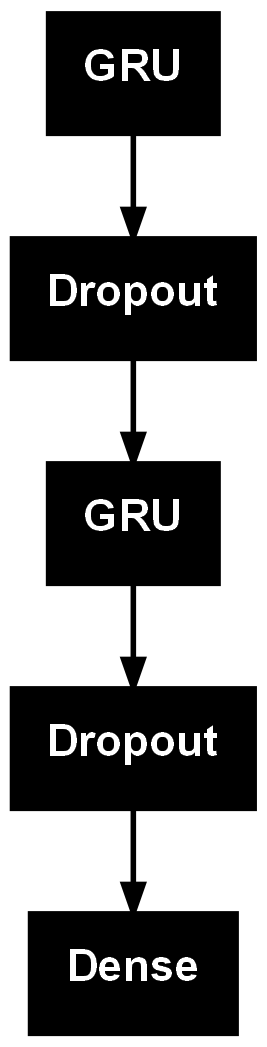

In [2]:
from keras.utils import plot_model

plot_model(gru_model)